In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import numpy as np
import pandas as pd
import json
import joblib

In [47]:
batch_size = 64
num_channels = 1
latent_dim = 128

## Data Preprocessing

In [277]:
with open('match_1.json', 'r') as json_file:
    data = json.load(json_file)

scaler = StandardScaler()

df = pd.DataFrame(data)
df = df.explode('norm')

labels = np.array(df['label'])
features = np.array(df['norm']).astype(np.float32) 
features_normalized = scaler.fit_transform(features.reshape(-1, 1))

num_classes = len(np.unique(labels))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
all_labels = keras.utils.to_categorical(encoded_labels, num_classes)

features_normalized, all_labels = shuffle(features_normalized, all_labels, random_state=42)

features_resampled = features_normalized.reshape(-1, 1, 1)

dataset = tf.data.Dataset.from_tensor_slices((features_resampled, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [278]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

## Model Architecture

In [279]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((1, discriminator_in_channels)),
        layers.Dense(64),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

generator = keras.Sequential(
    [
        layers.InputLayer((generator_in_channels,)),
        layers.Dense(128),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1),
        layers.Reshape((1, 1))
    ],
    name="generator",
)

In [280]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, num_classes):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )
        image_one_hot_labels = one_hot_labels[:, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[1]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, 1, num_classes)
        )
        generated_images = self.generator(random_vector_labels)
        
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )
       
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [281]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim, num_classes=num_classes
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [327]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1, 64)             640       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 64)            256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 1, 64)             0         
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 961
Trainable params: 833
Non-trainable params: 128
_____________________________________________________

In [328]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               17536     
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
 reshape_3 (Reshape)         (None, 1, 1)              0         
                                                         

In [282]:
cond_gan.fit(dataset, epochs=500)

Epoch 1/500
436/436 [==============================] - 3s 5ms/step - g_loss: 0.7133 - d_loss: 0.6906
Epoch 2/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.7036 - d_loss: 0.6853
Epoch 3/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7116 - d_loss: 0.6792
Epoch 4/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.7141 - d_loss: 0.6751
Epoch 5/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7232 - d_loss: 0.6701
Epoch 6/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7333 - d_loss: 0.6708
Epoch 7/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7105 - d_loss: 0.6811
Epoch 8/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7225 - d_loss: 0.6761
Epoch 9/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7254 - d_loss: 0.6755
Epoch 10/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.7218 - d_lo

436/436 [==============================] - 2s 5ms/step - g_loss: 0.6946 - d_loss: 0.6927
Epoch 161/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6947 - d_loss: 0.6925
Epoch 162/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6948 - d_loss: 0.6923
Epoch 163/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6964 - d_loss: 0.6919
Epoch 164/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6946 - d_loss: 0.6924
Epoch 165/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6950 - d_loss: 0.6921
Epoch 166/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6954 - d_loss: 0.6917
Epoch 167/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6951 - d_loss: 0.6922
Epoch 168/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6948 - d_loss: 0.6931
Epoch 169/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6953 -

436/436 [==============================] - 2s 4ms/step - g_loss: 0.6949 - d_loss: 0.6935
Epoch 319/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6966 - d_loss: 0.6916
Epoch 320/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6979 - d_loss: 0.6922
Epoch 321/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6946 - d_loss: 0.6932
Epoch 322/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6943 - d_loss: 0.6926
Epoch 323/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6939 - d_loss: 0.6927
Epoch 324/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6941 - d_loss: 0.6924
Epoch 325/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6948 - d_loss: 0.6926
Epoch 326/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6945 - d_loss: 0.6930
Epoch 327/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6983 -

436/436 [==============================] - 2s 4ms/step - g_loss: 0.6943 - d_loss: 0.6926
Epoch 477/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6942 - d_loss: 0.6927
Epoch 478/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6945 - d_loss: 0.6933
Epoch 479/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6935 - d_loss: 0.6934
Epoch 480/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6954 - d_loss: 0.6932
Epoch 481/500
436/436 [==============================] - 2s 4ms/step - g_loss: 0.6945 - d_loss: 0.6923
Epoch 482/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6947 - d_loss: 0.6928
Epoch 483/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6946 - d_loss: 0.6930
Epoch 484/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6947 - d_loss: 0.6928
Epoch 485/500
436/436 [==============================] - 2s 5ms/step - g_loss: 0.6946 -

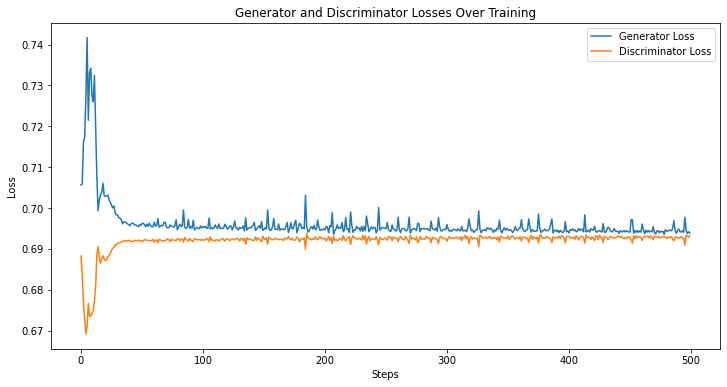

In [283]:
plt.figure(figsize=(12, 6))
plt.plot(cond_gan.history.history['g_loss'], label='Generator Loss')
plt.plot(cond_gan.history.history['d_loss'], label='Discriminator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Losses Over Training')
plt.show()

In [340]:
label_to_encoded = {label: encoded for label, encoded in zip(labels, encoded_labels)}

In [98]:
label_to_encoded

{'walk': 7,
 'rest': 3,
 'run': 4,
 'tackle': 6,
 'dribble': 1,
 'pass': 2,
 'cross': 0,
 'shot': 5}

In [342]:
generator.save('generator_model.h5')
joblib.dump(scaler, 'generator_scaler.pkl')
joblib.dump(label_to_encoded, 'generator_classes.pkl')